# 1. Library dan Setup

## 1.1 Import Library

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## 1.2 Mount Google Drive

In [ ]:
drive.mount('/content/drive')
base_file_path = "/content/drive/My Drive/TA/"
if not os.path.exists(base_file_path):
    os.makedirs(base_file_path)

Mounted at /content/drive


# 2. Preprocessing

## 2.1 Membaca Dataset

In [ ]:
books_file_path = "/content/drive/My Drive/TA/BooksDataSet.csv"
books = pd.read_csv(books_file_path, sep=';')
books = pd.DataFrame(books, columns=['book_id', 'book_name', 'genre', 'summary'])

## 2.2 Filter Genre dan Membersihkan Data

In [ ]:
selected_genres = ['Crime Fiction', 'Fantasy', 'Historical novel', 'Horror', 'Science Fiction', 'Thriller']
books = books[books['genre'].isin(selected_genres)]
books['summary'] = books['summary'].fillna('').apply(lambda x: x.lower())

<ipython-input-4-e85bda240740>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['summary'] = books['summary'].fillna('').apply(lambda x: x.lower())


In [ ]:
print("Snapshot of books dataframe")
books

Snapshot of books dataframe


,book_id,book_name,genre,summary
0,3248537,Drowned Wednesday,Fantasy,drowned wednesday is the first trustee among ...
1,27796919,The Lost Hero,Fantasy,"as the book opens, jason awakens on a school ..."
2,3910776,The Eyes of the Overworld,Fantasy,cugel is easily persuaded by the merchant fia...
3,5969644,Magic's Promise,Fantasy,the book opens with herald-mage vanyel return...
4,3173445,Taran Wanderer,Fantasy,taran and gurgi have returned to caer dallben...
...,...,...,...,...
2991,10372180,White Death,Thriller,"a novel from the numa files, a kurt austin ad..."
2992,14504372,Venus with Pistol,Thriller,gilbert kemp is dealer specializing in antiqu...
2993,3617412,Blackwater,Thriller,"""how do you know when you're in too deep? dav..."
2994,11320975,The Rainbow and the Rose,Thriller,the story concerns the life of johnnie pascoe...


In [ ]:
books.groupby('genre').count()

,book_id,book_name,summary
genre,,,
Crime Fiction,499,499,499
Fantasy,498,498,498
Historical novel,499,499,499
Horror,499,499,499
Science Fiction,500,500,500
Thriller,500,500,500


## 2.3 Tokenisasi dan Membersihkan Teks

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemma.lemmatize(word) for word in tokens]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

books['summary'] = books['summary'].apply(clean_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Menampilkan hasil tokenisasi
print(books['summary'].head())

0    [drown, wednesday, first, truste, among, morro...
1    [book, open, jason, awaken, school, bu, unabl,...
2    [cugel, easili, persuad, merchant, fianosth, a...
3    [book, open, heraldmag, vanyel, return, countr...
4    [taran, gurgi, return, caer, dallben, follow, ...
Name: summary, dtype: object


## 2.4 Label Encoding dan Train-Test Split

In [ ]:
LE = LabelEncoder()
y = LE.fit_transform(books['genre'])
xtrain, xval, ytrain, yval = train_test_split(books['summary'], y, test_size=0.2, random_state=557)

In [ ]:
print("Label encoding:")
print(dict(zip(LE.classes_, range(len(LE.classes_)))))

Label encoding:
{'Crime Fiction': 0, 'Fantasy': 1, 'Historical novel': 2, 'Horror': 3, 'Science Fiction': 4, 'Thriller': 5}


## 2.5 TF-IDF Vectorization

In [ ]:
# Inisialisasi TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain_tfidf = tfidf_vectorizer.fit_transform([' '.join(text) for text in xtrain])
xval_tfidf = tfidf_vectorizer.transform([' '.join(text) for text in xval])

# Konversi hasil menjadi array
xtrain_tfidf = xtrain_tfidf.toarray()
xval_tfidf = xval_tfidf.toarray()
print(f"xtrain_tfidf shape: {xtrain_tfidf.shape}")
print(f"xval_tfidf shape: {xval_tfidf.shape}")

xtrain_tfidf shape: (2396, 10000)
xval_tfidf shape: (599, 10000)


# 3. Model

## 3.1 Membuat Model SVM

In [ ]:
svc_linear = svm.SVC(kernel='linear', C=1.0)
svc_poly = svm.SVC(kernel='poly', degree=3, C=1.0)
svc_rbf = svm.SVC(kernel='rbf', C=1.0, gamma='scale')


#4. Training Model

## 4.1 Model Linear

In [ ]:
svc_linear.fit(xtrain_tfidf, ytrain)

SVC(kernel='linear')

### Save Model

In [ ]:
joblib.dump(svc_linear, f"{base_file_path}model_svm_linear.pkl")

['/content/drive/My Drive/TA/model_svm_linear.pkl']

## 4.1 Model Polynomial

In [ ]:
svc_poly.fit(xtrain_tfidf, ytrain)

SVC(kernel='poly')

### Save Model

In [ ]:
joblib.dump(svc_poly, f"{base_file_path}model_svm_poly.pkl")

['/content/drive/My Drive/TA/model_svm_poly.pkl']

## 4.1 Model RFB

In [ ]:
svc_rbf.fit(xtrain_tfidf, ytrain)

SVC()

### Save Model

In [ ]:
joblib.dump(svc_rbf, f"{base_file_path}model_svm_rbf.pkl")

['/content/drive/My Drive/TA/model_svm_rbf.pkl']

# 5. Evaluasi

## 5.1 Fungsi Untuk Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, target_names, title="Confusion Matrix"):
    """
    Menampilkan confusion matrix dengan penataan yang lebih rapi.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names,
                cbar=False, annot_kws={"size": 12})
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 5.2 Fungsi Untuk Plot Classification Matrix

In [ ]:
def plot_classification_metrics(y_true, y_pred, target_names):
    """
    Menampilkan bar plot untuk Precision, Recall, F1, dan Akurasi per kelas.
    """
    # Hitung metrik utama
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)

    # Menghitung akurasi per kelas
    cm = confusion_matrix(y_true, y_pred)  # Matriks kebingungannya
    class_accuracy = cm.diagonal() / cm.sum(axis=1)  # True Positives / Jumlah per kelas

    # Membuat dataframe untuk plot
    metrics_df = pd.DataFrame({
        'Accuracy': class_accuracy,  # Akurasi per kelas
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }, index=target_names)

    # Membuat bar plot
    ax = metrics_df.plot(kind='bar', figsize=(12, 6), width=0.8, color = ['#7fbbff', '#4c8fbc', '#2e6a8e', '#1f3a5a'], fontsize=12)

    # Menambahkan title dan label
    ax.set_title("Precision, Recall, F1 Score, and Accuracy per Class", fontsize=14)
    ax.set_xlabel('Classes', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xticklabels(target_names, rotation=45)
    ax.legend(title="Metrics", fontsize=12)

    # Menampilkan angka di atas setiap bar dengan format 0.00
    for container in ax.containers:
        ax.bar_label(container, label_type='edge', fontsize=10, color='black', padding=3, fmt='%.2f')

    # Rapi layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Memberikan ruang untuk teks akurasi
    plt.show()


## 5.3 Fungsi Untuk Memuat dan Mengevaluasi Model

In [ ]:
def load_and_evaluate_model(model_name, x_val, y_val, target_names):
    """
    Meload model dari file, melakukan evaluasi, dan mencetak nilai metrik utama.
    """
    # Path file model
    file_path = f"{base_file_path}{model_name}.pkl"

    # Load model
    model = joblib.load(file_path)
    print(f"\n{'-'*50}")
    print(f"Model '{model_name}' loaded successfully from {file_path}")
    print(f"{'-'*50}\n")

    # Prediksi
    y_pred = model.predict(x_val)

    # Hitung metrik
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average="macro")
    recall = recall_score(y_val, y_pred, average="macro")
    f1 = f1_score(y_val, y_pred, average="macro")

    # Tampilkan hasil evaluasi
    print(f"\nEvaluation results for model '{model_name}':\n")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=target_names))
    print(f"{'-'*50}\n")

    # Plotting
    plot_confusion_matrix(y_val, y_pred, target_names)
    print("\n\n")
    plot_classification_metrics(y_val, y_pred, target_names)


## 5.4 Evaluasi Model SVM Linear


--------------------------------------------------
Model 'model_svm_linear' loaded successfully from /content/drive/My Drive/TA/model_svm_linear.pkl
--------------------------------------------------


Evaluation results for model 'model_svm_linear':

Accuracy: 0.6878
Precision: 0.6877
Recall: 0.6880
F1 Score: 0.6865

Classification Report:
                  precision    recall  f1-score   support

   Crime Fiction       0.75      0.70      0.72       109
         Fantasy       0.68      0.71      0.69        89
Historical novel       0.71      0.72      0.72        97
          Horror       0.70      0.60      0.64       107
 Science Fiction       0.72      0.75      0.73       107
        Thriller       0.57      0.66      0.61        90

        accuracy                           0.69       599
       macro avg       0.69      0.69      0.69       599
    weighted avg       0.69      0.69      0.69       599

--------------------------------------------------



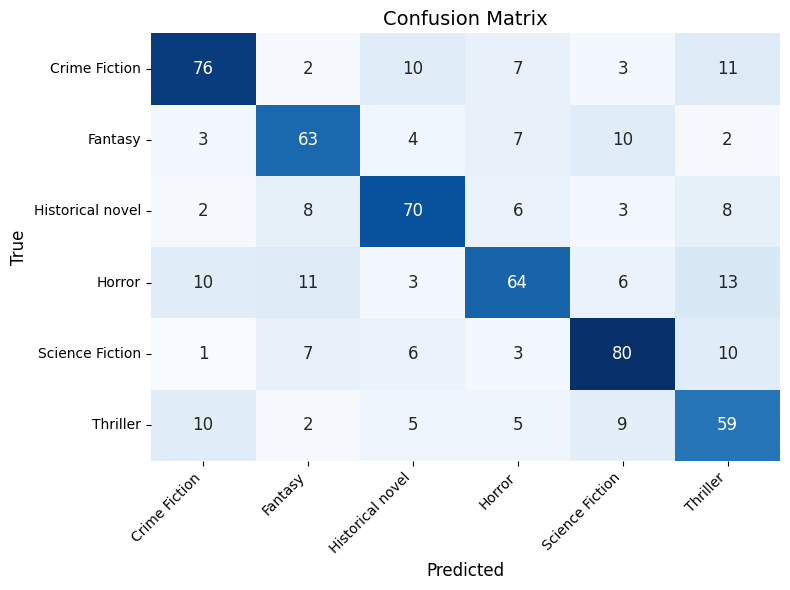

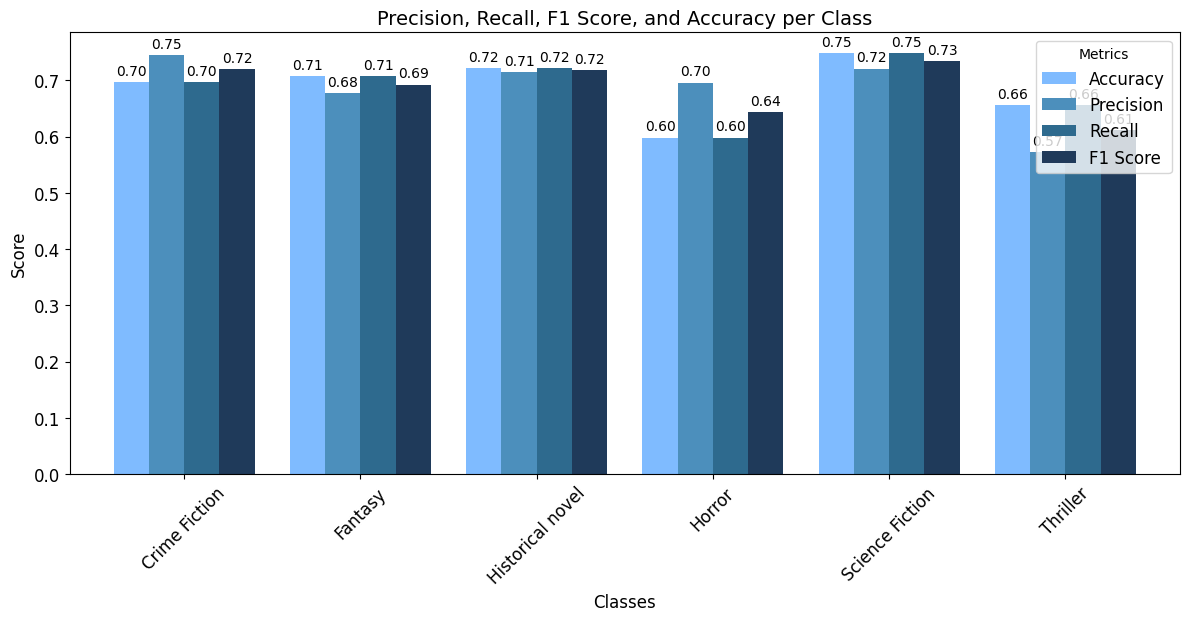

In [ ]:
load_and_evaluate_model("model_svm_linear", xval_tfidf, yval, selected_genres)

## 5.5 Evaluasi Model SVM Polynomial


--------------------------------------------------
Model 'model_svm_poly' loaded successfully from /content/drive/My Drive/TA/model_svm_poly.pkl
--------------------------------------------------


Evaluation results for model 'model_svm_poly':

Accuracy: 0.4825
Precision: 0.6408
Recall: 0.4970
F1 Score: 0.4844

Classification Report:
                  precision    recall  f1-score   support

   Crime Fiction       0.76      0.28      0.41       109
         Fantasy       0.31      0.78      0.44        89
Historical novel       0.70      0.40      0.51        97
          Horror       0.88      0.28      0.43       107
 Science Fiction       0.83      0.50      0.62       107
        Thriller       0.38      0.74      0.50        90

        accuracy                           0.48       599
       macro avg       0.64      0.50      0.48       599
    weighted avg       0.66      0.48      0.48       599

--------------------------------------------------



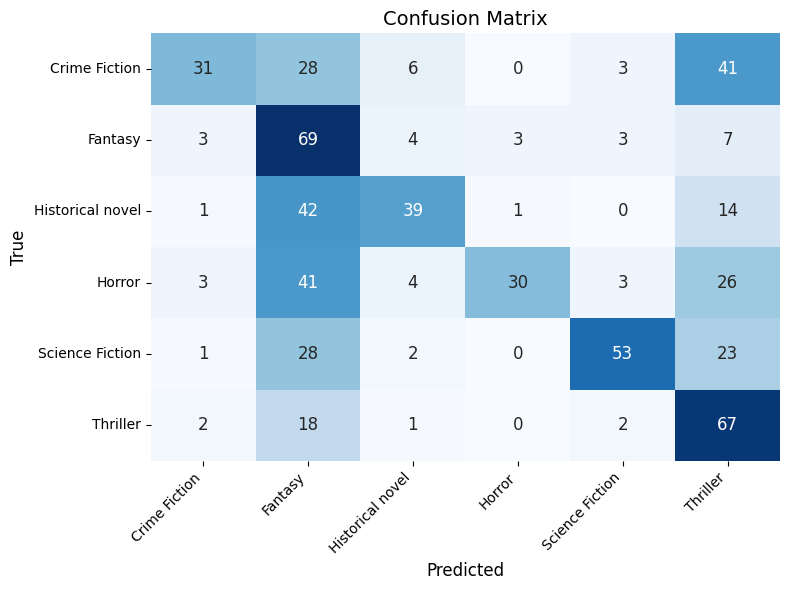

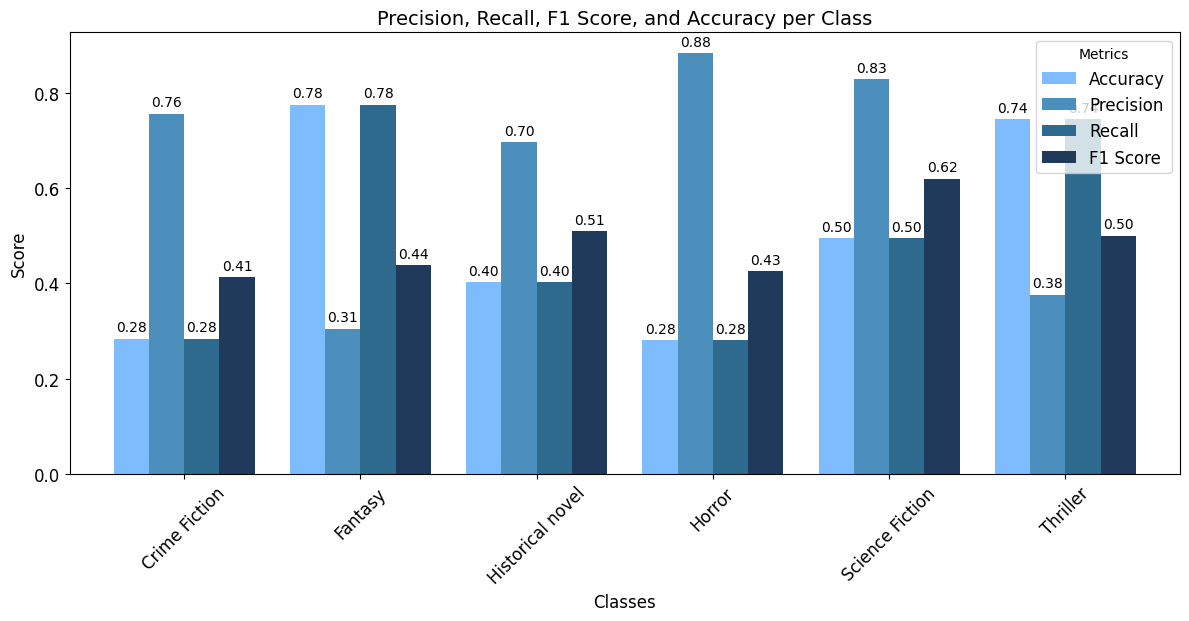

In [ ]:
load_and_evaluate_model("model_svm_poly", xval_tfidf, yval, selected_genres)

## 5.6 Evaluasi Model SVM RBF


--------------------------------------------------
Model 'model_svm_rbf' loaded successfully from /content/drive/My Drive/TA/model_svm_rbf.pkl
--------------------------------------------------


Evaluation results for model 'model_svm_rbf':

Accuracy: 0.6895
Precision: 0.6981
Recall: 0.6919
F1 Score: 0.6895

Classification Report:
                  precision    recall  f1-score   support

   Crime Fiction       0.79      0.68      0.73       109
         Fantasy       0.63      0.74      0.68        89
Historical novel       0.70      0.73      0.72        97
          Horror       0.73      0.57      0.64       107
 Science Fiction       0.80      0.73      0.76       107
        Thriller       0.53      0.70      0.60        90

        accuracy                           0.69       599
       macro avg       0.70      0.69      0.69       599
    weighted avg       0.71      0.69      0.69       599

--------------------------------------------------



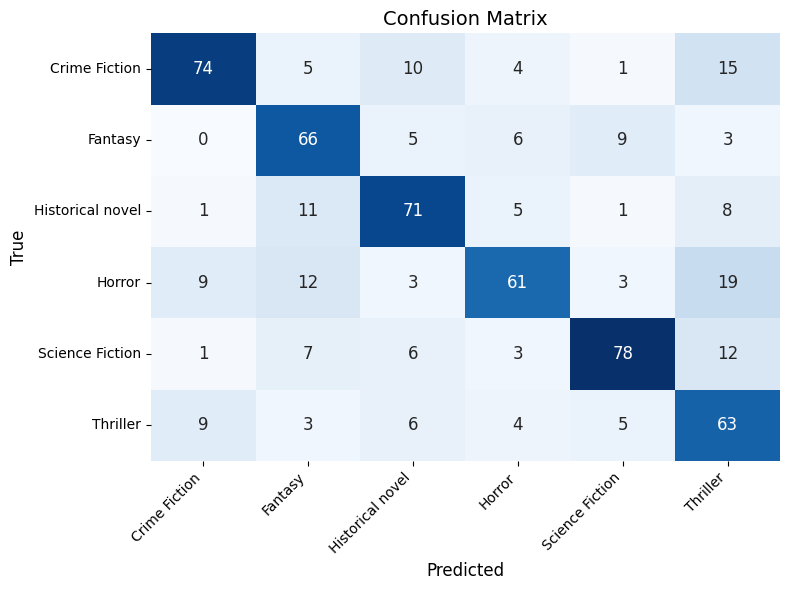

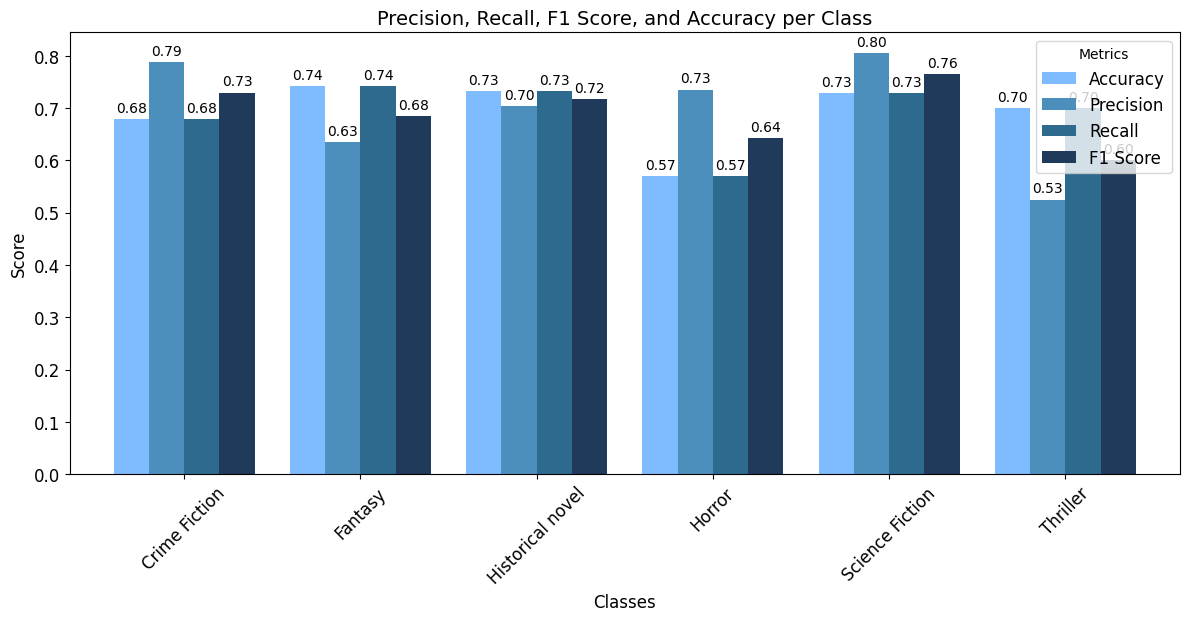

In [ ]:
load_and_evaluate_model("model_svm_rbf", xval_tfidf, yval, selected_genres)